Navigate to <code>/chest_xray_code/data</code> and run 
<code>wget https://openi.nlm.nih.gov/imgs/collections/NLMCXR_png.tgz</code>
<code>wget https://openi.nlm.nih.gov/imgs/collections/NLMCXR_reports.tgz</code>

Then decompress them, and make sure they're in a directory called <code>/raw_reports</code> and <code>/xrays</code> respectively... (one of them decompresses to its own directory, so you need to rename that directory raw_reports instead of encgn or whatever).


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import matplotlib.pyplot as plt

import torchvision.datasets as dset
import torchvision.transforms as T
#import final_proj_code.chest_xray_code.src.preprocess_dataset as preprocess_dataset
#import final_proj_code.chest_xray_code.src.utils as utils
import os
import torch.nn.functional as F


import numpy as np

Navigate to final_proj_code/chest_xray_code/src and run 

<code> python preprocess_dataset.py </code>

Now the data is stored in a numpy array in <code>../data/dataset.npy</code> 

In [2]:
#X, Y = utils.load_X_and_Y()
#x_train, x_dev, x_test = X
#y_train, y_dev, y_test = Y



In [3]:
def imshow_noax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img)
    plt.gca().axis('off')

In [4]:
NUM_TRAIN = 100

# The torchvision.transforms package provides tools for preprocessing data
# and for performing data augmentation; here we set up a transform to
# preprocess the data by subtracting the mean RGB value and dividing by the
# standard deviation of each RGB value; we've hardcoded the mean and std.
transform = T.Compose([
                T.ToTensor()
                #T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

# We set up a Dataset object for each split (train / val / test); Datasets load
# training examples one at a time, so we wrap each Dataset in a DataLoader which
# iterates through the Dataset and forms minibatches. We divide the CIFAR-10
# training set into train and val sets by passing a Sampler object to the
# DataLoader telling how it should sample from the underlying Dataset.
cifar10_train = dset.CIFAR10('./cs231n/datasets', train=True, download=True,
                             transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=64, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = dset.CIFAR10('./cs231n/datasets', train=True, download=True,
                           transform=transform)
loader_val = DataLoader(cifar10_val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 150)))

cifar10_test = dset.CIFAR10('./cs231n/datasets', train=False, download=True, 
                            transform=transform)
loader_test = DataLoader(cifar10_test, batch_size=64)

images = {}

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


You have an option to **use GPU by setting the flag to True below**. It is not necessary to use GPU for this assignment. Note that if your computer does not have CUDA enabled, `torch.cuda.is_available()` will return False and this notebook will fallback to CPU mode.

The global variables `dtype` and `device` will control the data types throughout this assignment. 

In [5]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cpu


In [6]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

def test_flatten():
    x = torch.arange(12).view(2, 1, 3, 2)
    print('Before flattening: ', x)
    print('After flattening: ', flatten(x))

test_flatten()

Before flattening:  tensor([[[[  0.,   1.],
          [  2.,   3.],
          [  4.,   5.]]],


        [[[  6.,   7.],
          [  8.,   9.],
          [ 10.,  11.]]]])
After flattening:  tensor([[  0.,   1.,   2.,   3.,   4.,   5.],
        [  6.,   7.,   8.,   9.,  10.,  11.]])


### Module API: Check Accuracy
Given the validation or test set, we can check the classification accuracy of a neural network. 

This version is slightly different from the one in part II. You don't manually pass in the parameters anymore.

In [7]:
def check_accuracy_part34(loader, model):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)

        
    i = 0
    for image in x:
        images[image] = scores[i]
        i += 1

### Module API: Training Loop
We also use a slightly different training loop. Rather than updating the values of the weights ourselves, we use an Optimizer object from the `torch.optim` package, which abstract the notion of an optimization algorithm and provides implementations of most of the algorithms commonly used to optimize neural networks.

# Part IV. PyTorch Sequential API

Part III introduced the PyTorch Module API, which allows you to define arbitrary learnable layers and their connectivity. 

For simple models like a stack of feed forward layers, you still need to go through 3 steps: subclass `nn.Module`, assign layers to class attributes in `__init__`, and call each layer one by one in `forward()`. Is there a more convenient way? 

Fortunately, PyTorch provides a container Module called `nn.Sequential`, which merges the above steps into one. It is not as flexible as `nn.Module`, because you cannot specify more complex topology than a feed-forward stack, but it's good enough for many use cases.

### Sequential API: Two-Layer Network
Let's see how to rewrite our two-layer fully connected network example with `nn.Sequential`, and train it using the training loop defined above.

Again, you don't need to tune any hyperparameters here, but you shoud achieve above 40% accuracy after one epoch of training.

In [8]:
def train_part34(model, optimizer, epochs=10):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    loss_history = []
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float)

            reconstruction = model(x)
            loss_function = nn.MSELoss(size_average=False)
            loss = loss_function(reconstruction, x)
            #i = 0
            #for image in x:
                #images[image] = reconstruction[i]
                #imshow_noax(image, normalize=False)
                #imshow_noax(reconstruction[i], normalize=False)
                #plt.imshow(image.detach().numpy().transpose(2,1,0))
                #plt.imshow(reconstruction[i].detach().numpy().transpose(2,1,0))
                #i += 1

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()
            loss_history.append(loss.item())

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
            

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                #check_accuracy_part34(loader_val, model)
                print()

# Part V. CIFAR-10 open-ended challenge

In this section, you can experiment with whatever ConvNet architecture you'd like on CIFAR-10. 

Now it's your job to experiment with architectures, hyperparameters, loss functions, and optimizers to train a model that achieves **at least 70%** accuracy on the CIFAR-10 **validation** set within 10 epochs. You can use the check_accuracy and train functions from above. You can use either `nn.Module` or `nn.Sequential` API. 

Describe what you did at the end of this notebook.

Here are the official API documentation for each component. One note: what we call in the class "spatial batch norm" is called "BatchNorm2D" in PyTorch.

* Layers in torch.nn package: http://pytorch.org/docs/stable/nn.html
* Activations: http://pytorch.org/docs/stable/nn.html#non-linear-activations
* Loss functions: http://pytorch.org/docs/stable/nn.html#loss-functions
* Optimizers: http://pytorch.org/docs/stable/optim.html


### Things you might try:
- **Filter size**: Above we used 5x5; would smaller filters be more efficient?
- **Number of filters**: Above we used 32 filters. Do more or fewer do better?
- **Pooling vs Strided Convolution**: Do you use max pooling or just stride convolutions?
- **Batch normalization**: Try adding spatial batch normalization after convolution layers and vanilla batch normalization after affine layers. Do your networks train faster?
- **Network architecture**: The network above has two layers of trainable parameters. Can you do better with a deep network? Good architectures to try include:
    - [conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [conv-relu-conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [batchnorm-relu-conv]xN -> [affine]xM -> [softmax or SVM]
- **Global Average Pooling**: Instead of flattening and then having multiple affine layers, perform convolutions until your image gets small (7x7 or so) and then perform an average pooling operation to get to a 1x1 image picture (1, 1 , Filter#), which is then reshaped into a (Filter#) vector. This is used in [Google's Inception Network](https://arxiv.org/abs/1512.00567) (See Table 1 for their architecture).
- **Regularization**: Add l2 weight regularization, or perhaps use Dropout.

### Tips for training
For each network architecture that you try, you should tune the learning rate and other hyperparameters. When doing this there are a couple important things to keep in mind:

- If the parameters are working well, you should see improvement within a few hundred iterations
- Remember the coarse-to-fine approach for hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all.
- Once you have found some sets of parameters that seem to work, search more finely around these parameters. You may need to train for more epochs.
- You should use the validation set for hyperparameter search, and save your test set for evaluating your architecture on the best parameters as selected by the validation set.

### Going above and beyond
If you are feeling adventurous there are many other features you can implement to try and improve your performance. You are **not required** to implement any of these, but don't miss the fun if you have time!

- Alternative optimizers: you can try Adam, Adagrad, RMSprop, etc.
- Alternative activation functions such as leaky ReLU, parametric ReLU, ELU, or MaxOut.
- Model ensembles
- Data augmentation
- New Architectures
  - [ResNets](https://arxiv.org/abs/1512.03385) where the input from the previous layer is added to the output.
  - [DenseNets](https://arxiv.org/abs/1608.06993) where inputs into previous layers are concatenated together.
  - [This blog has an in-depth overview](https://chatbotslife.com/resnets-highwaynets-and-densenets-oh-my-9bb15918ee32)

### Have fun and happy training! 

In [9]:
################################################################################
# TODO:                                                                        #         
# Experiment with any architectures, optimizers, and hyperparameters.          #
# Achieve AT LEAST 70% accuracy on the *validation set* within 10 epochs.      #
#                                                                              #
# Note that you can use the check_accuracy function to evaluate on either      #
# the test set or the validation set, by passing either loader_test or         #
# loader_val as the second argument to check_accuracy. You should not touch    #
# the test set until you have finished your architecture and  hyperparameter   #
# tuning, and only run the test set once at the end to report a final value.   #
################################################################################
class TestConvNet(nn.Module):
    def __init__(self,channels,size):
        super().__init__()

        self.conv_1_compress = nn.Conv2d(channels, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.relu_1_compress = nn.ReLU()
        
        self.conv_2_compress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_2_compress = nn.BatchNorm2d(size)
        self.relu_2_compress = nn.ReLU()
        
        self.conv_3_compress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_3_compress = nn.BatchNorm2d(size)
        self.relu_3_compress = nn.ReLU()
        
        self.conv_4_compress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_4_compress = nn.BatchNorm2d(size)
        self.relu_4_compress = nn.ReLU()
        
        self.conv_5_compress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_5_compress = nn.BatchNorm2d(size)
        self.relu_5_compress = nn.ReLU()
        
        self.conv_6_compress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_6_compress = nn.BatchNorm2d(size)
        self.relu_6_compress = nn.ReLU()

        self.conv_downsize_compress = nn.Conv2d(size, size, kernel_size=3,stride=2,padding=1,bias=True)
        self.batchnorm_downsize_compress = nn.BatchNorm2d(size)
        self.relu_downsize_compress = nn.ReLU()
        
        self.conv_7_compress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_7_compress = nn.BatchNorm2d(size)
        self.relu_7_compress = nn.ReLU()
        
        self.conv_8_compress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_8_compress = nn.BatchNorm2d(size)
        self.relu_8_compress = nn.ReLU()
        
        self.conv_9_compress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_9_compress = nn.BatchNorm2d(size)
        self.relu_9_compress = nn.ReLU()
        
        self.conv_10_compress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_10_compress = nn.BatchNorm2d(size)
        self.relu_10_compress = nn.ReLU()
        
        
        
        self.conv_compress_final = nn.Conv2d(size, channels, kernel_size=3,stride=1,padding=1,bias=True)
        
        self.upscaling = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv_1_decompress = nn.Conv2d(channels, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.relu_1_decompress = nn.ReLU()
        
        self.conv_2_decompress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_2_decompress = nn.BatchNorm2d(size)
        self.relu_2_decompress = nn.ReLU()
        
        self.conv_3_decompress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_3_decompress = nn.BatchNorm2d(size)
        self.relu_3_decompress = nn.ReLU()
        
        self.conv_4_decompress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_4_decompress = nn.BatchNorm2d(size)
        self.relu_4_decompress = nn.ReLU()
        
        self.conv_5_decompress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_5_decompress = nn.BatchNorm2d(size)
        self.relu_5_decompress = nn.ReLU()
        
        self.conv_6_decompress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_6_decompress = nn.BatchNorm2d(size)
        self.relu_6_decompress = nn.ReLU()
        
        self.conv_7_decompress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_7_decompress = nn.BatchNorm2d(size)
        self.relu_7_decompress = nn.ReLU()
        
        self.conv_8_decompress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_8_decompress = nn.BatchNorm2d(size)
        self.relu_8_decompress = nn.ReLU()
        
        self.conv_9_decompress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_9_decompress = nn.BatchNorm2d(size)
        self.relu_9_decompress = nn.ReLU()
        
        self.conv_10_decompress = nn.Conv2d(size, 3, kernel_size=3,stride=1,padding=1,bias=True)
        

    def forward(self, x):
        scores = None
        model = torch.nn.Sequential( 
            
            self.conv_1_compress,
            self.relu_1_compress,
        
            self.conv_2_compress,
            self.batchnorm_2_compress,
            self.relu_2_compress,
            
            self.conv_3_compress,
            self.batchnorm_3_compress,
            self.relu_3_compress,
            
            self.conv_4_compress,
            self.batchnorm_4_compress,
            self.relu_4_compress,
            
            self.conv_5_compress,
            self.batchnorm_5_compress,
            self.relu_5_compress,
            
            self.conv_6_compress,
            self.batchnorm_6_compress,
            self.relu_6_compress,
            
            self.conv_downsize_compress,
            self.batchnorm_downsize_compress,
            self.relu_downsize_compress,
            
            self.conv_7_compress,
            self.batchnorm_7_compress,
            self.relu_7_compress,
            
            self.conv_8_compress,
            self.batchnorm_8_compress,
            self.relu_8_compress,
            
            self.conv_9_compress,
            self.batchnorm_9_compress,
            self.relu_9_compress,
            
            self.conv_10_compress,
            self.batchnorm_10_compress,
            self.relu_10_compress,
            
            self.conv_compress_final,
        
            self.upscaling,
            
            self.conv_1_decompress,
            self.relu_1_decompress,
        
            self.conv_2_decompress,
            self.batchnorm_2_decompress,
            self.relu_2_decompress,
            
            self.conv_3_decompress,
            self.batchnorm_3_decompress,
            self.relu_3_decompress,
            
            self.conv_4_decompress,
            self.batchnorm_4_decompress,
            self.relu_4_decompress,
            
            self.conv_5_decompress,
            self.batchnorm_5_decompress,
            self.relu_5_decompress,
            
            self.conv_6_decompress,
            self.batchnorm_6_decompress,
            self.relu_6_decompress,
            
            self.conv_7_decompress,
            self.batchnorm_7_decompress,
            self.relu_7_decompress,
            
            self.conv_8_decompress,
            self.batchnorm_8_decompress,
            self.relu_8_decompress,
            
            self.conv_9_decompress,
            self.batchnorm_9_decompress,
            self.relu_9_decompress,
        
            self.conv_10_decompress

            
        ).to(device)
        scores = model(x)
        return scores
    


class Flatten(nn.Module):
    def forward(self, x):
        x = x.view(x.size()[0], -1)
        return x

channels = 3
size = 32

model = TestConvNet(channels, size)
optimizer = optim.Adam(model.parameters(), lr=5e-3)
                     #momentum=0.9, nesterov=True)#optim.SGD(model.parameters(), lr=5e-3)

################################################################################
#                                 END OF YOUR CODE                             
################################################################################

# You should get at least 70% accuracy
train_part34(model, optimizer, epochs=5000)

Iteration 0, loss = 71235.9922

Iteration 0, loss = 17963.8984

Iteration 0, loss = 17741.3223

Iteration 0, loss = 13065.2236

Iteration 0, loss = 10567.2900

Iteration 0, loss = 9281.8750

Iteration 0, loss = 7295.9883

Iteration 0, loss = 7406.3345

Iteration 0, loss = 7097.9912

Iteration 0, loss = 6329.7192

Iteration 0, loss = 6261.2441

Iteration 0, loss = 6256.5103

Iteration 0, loss = 6673.3818

Iteration 0, loss = 6424.7085

Iteration 0, loss = 6270.5117

Iteration 0, loss = 5708.5483

Iteration 0, loss = 5966.6973

Iteration 0, loss = 6072.3594

Iteration 0, loss = 5867.1772

Iteration 0, loss = 5572.7686

Iteration 0, loss = 5436.7188

Iteration 0, loss = 5474.3135

Iteration 0, loss = 4935.4556

Iteration 0, loss = 5003.1016

Iteration 0, loss = 4903.1885

Iteration 0, loss = 4753.9141

Iteration 0, loss = 4744.7261

Iteration 0, loss = 4422.5859

Iteration 0, loss = 4256.8579

Iteration 0, loss = 4077.2671

Iteration 0, loss = 4201.0645

Iteration 0, loss = 4365.5410

Ite

Iteration 0, loss = 1120.3104

Iteration 0, loss = 1091.6791

Iteration 0, loss = 866.7346

Iteration 0, loss = 945.6224

Iteration 0, loss = 1010.6957

Iteration 0, loss = 912.1279

Iteration 0, loss = 902.3030

Iteration 0, loss = 806.8942

Iteration 0, loss = 853.6807

Iteration 0, loss = 946.2556

Iteration 0, loss = 895.0236

Iteration 0, loss = 905.1281

Iteration 0, loss = 876.9623

Iteration 0, loss = 926.4782

Iteration 0, loss = 997.2414

Iteration 0, loss = 974.3854

Iteration 0, loss = 969.0548

Iteration 0, loss = 1072.7257

Iteration 0, loss = 943.3309

Iteration 0, loss = 851.7713

Iteration 0, loss = 919.9980

Iteration 0, loss = 957.9235

Iteration 0, loss = 943.8988

Iteration 0, loss = 903.7122

Iteration 0, loss = 919.4914

Iteration 0, loss = 974.3260

Iteration 0, loss = 828.4879

Iteration 0, loss = 793.3622

Iteration 0, loss = 934.4222

Iteration 0, loss = 858.3956

Iteration 0, loss = 977.0787

Iteration 0, loss = 934.6758

Iteration 0, loss = 945.3182

Iterat

Iteration 0, loss = 627.0476

Iteration 0, loss = 642.7462

Iteration 0, loss = 574.7372

Iteration 0, loss = 526.5414

Iteration 0, loss = 685.0435

Iteration 0, loss = 681.8126

Iteration 0, loss = 597.2836

Iteration 0, loss = 736.9929

Iteration 0, loss = 592.1119

Iteration 0, loss = 621.3016

Iteration 0, loss = 645.1656

Iteration 0, loss = 599.9915

Iteration 0, loss = 585.3630

Iteration 0, loss = 605.1445

Iteration 0, loss = 607.1253

Iteration 0, loss = 691.7933

Iteration 0, loss = 604.5081

Iteration 0, loss = 574.2744

Iteration 0, loss = 592.7891

Iteration 0, loss = 574.9107

Iteration 0, loss = 588.4241

Iteration 0, loss = 620.1105

Iteration 0, loss = 582.3791

Iteration 0, loss = 594.8475

Iteration 0, loss = 579.4034

Iteration 0, loss = 603.3619

Iteration 0, loss = 596.1579

Iteration 0, loss = 628.7140

Iteration 0, loss = 593.5225

Iteration 0, loss = 631.6491

Iteration 0, loss = 564.6560

Iteration 0, loss = 619.7438

Iteration 0, loss = 657.8640

Iteration 

Iteration 0, loss = 460.0071

Iteration 0, loss = 518.5142

Iteration 0, loss = 610.3000

Iteration 0, loss = 610.7122

Iteration 0, loss = 551.5725

Iteration 0, loss = 501.0605

Iteration 0, loss = 503.3141

Iteration 0, loss = 522.3667

Iteration 0, loss = 467.5171

Iteration 0, loss = 507.2333

Iteration 0, loss = 478.4215

Iteration 0, loss = 471.9708

Iteration 0, loss = 436.6573

Iteration 0, loss = 464.9810

Iteration 0, loss = 420.9453

Iteration 0, loss = 457.7849

Iteration 0, loss = 536.8248

Iteration 0, loss = 401.9733

Iteration 0, loss = 391.9394

Iteration 0, loss = 448.7133

Iteration 0, loss = 407.9918

Iteration 0, loss = 463.3256

Iteration 0, loss = 437.0431

Iteration 0, loss = 440.9590

Iteration 0, loss = 493.4225

Iteration 0, loss = 478.9537

Iteration 0, loss = 665.2510

Iteration 0, loss = 445.3644

Iteration 0, loss = 548.4183

Iteration 0, loss = 487.4796

Iteration 0, loss = 451.3574

Iteration 0, loss = 510.4642

Iteration 0, loss = 490.3056

Iteration 

Iteration 0, loss = 311.3940

Iteration 0, loss = 315.0320

Iteration 0, loss = 322.8186

Iteration 0, loss = 342.4850

Iteration 0, loss = 328.1772

Iteration 0, loss = 325.6360

Iteration 0, loss = 357.5845

Iteration 0, loss = 374.1910

Iteration 0, loss = 399.6638

Iteration 0, loss = 434.4283

Iteration 0, loss = 484.2174

Iteration 0, loss = 593.6810

Iteration 0, loss = 565.2254

Iteration 0, loss = 462.4765

Iteration 0, loss = 408.8610

Iteration 0, loss = 375.8568

Iteration 0, loss = 426.9510

Iteration 0, loss = 317.8196

Iteration 0, loss = 472.1907

Iteration 0, loss = 465.4641

Iteration 0, loss = 464.2508

Iteration 0, loss = 571.2498

Iteration 0, loss = 440.5541

Iteration 0, loss = 405.4752

Iteration 0, loss = 396.3294

Iteration 0, loss = 369.6313

Iteration 0, loss = 389.3588

Iteration 0, loss = 381.1622

Iteration 0, loss = 328.7902

Iteration 0, loss = 334.3835

Iteration 0, loss = 345.8382

Iteration 0, loss = 363.1404

Iteration 0, loss = 318.9762

Iteration 

Iteration 0, loss = 284.9471

Iteration 0, loss = 360.7980

Iteration 0, loss = 287.7329

Iteration 0, loss = 283.9678

Iteration 0, loss = 290.5649

Iteration 0, loss = 270.0798

Iteration 0, loss = 358.8735

Iteration 0, loss = 293.4189

Iteration 0, loss = 286.6767

Iteration 0, loss = 320.8156

Iteration 0, loss = 280.2463

Iteration 0, loss = 307.9034

Iteration 0, loss = 322.7349

Iteration 0, loss = 276.1333

Iteration 0, loss = 298.8186

Iteration 0, loss = 273.4249

Iteration 0, loss = 280.7765

Iteration 0, loss = 264.9123

Iteration 0, loss = 304.4473

Iteration 0, loss = 391.6756

Iteration 0, loss = 330.1777

Iteration 0, loss = 259.8398

Iteration 0, loss = 270.2609

Iteration 0, loss = 276.1382

Iteration 0, loss = 372.6494

Iteration 0, loss = 392.4557

Iteration 0, loss = 373.8195

Iteration 0, loss = 323.1274

Iteration 0, loss = 319.1813

Iteration 0, loss = 329.8475

Iteration 0, loss = 331.5815

Iteration 0, loss = 343.1342

Iteration 0, loss = 287.7669

Iteration 

Iteration 0, loss = 239.3744

Iteration 0, loss = 217.0428

Iteration 0, loss = 266.9499

Iteration 0, loss = 251.9391

Iteration 0, loss = 243.3427

Iteration 0, loss = 228.5589

Iteration 0, loss = 240.6474

Iteration 0, loss = 243.5807

Iteration 0, loss = 307.0869

Iteration 0, loss = 249.3271

Iteration 0, loss = 266.1054

Iteration 0, loss = 252.5388

Iteration 0, loss = 338.5380

Iteration 0, loss = 254.6941

Iteration 0, loss = 265.4690

Iteration 0, loss = 260.1783

Iteration 0, loss = 268.0555

Iteration 0, loss = 245.9512

Iteration 0, loss = 301.1986

Iteration 0, loss = 245.2966

Iteration 0, loss = 219.2528

Iteration 0, loss = 292.2036

Iteration 0, loss = 237.1020

Iteration 0, loss = 243.1889

Iteration 0, loss = 229.1161

Iteration 0, loss = 306.5879

Iteration 0, loss = 286.4125

Iteration 0, loss = 270.0045

Iteration 0, loss = 270.0239

Iteration 0, loss = 288.6068

Iteration 0, loss = 238.4586

Iteration 0, loss = 252.0746

Iteration 0, loss = 234.0528

Iteration 

Iteration 0, loss = 275.7617

Iteration 0, loss = 287.0069

Iteration 0, loss = 258.3349

Iteration 0, loss = 220.9038

Iteration 0, loss = 265.7701

Iteration 0, loss = 227.6956

Iteration 0, loss = 249.6866

Iteration 0, loss = 268.9853

Iteration 0, loss = 242.1289

Iteration 0, loss = 220.2129

Iteration 0, loss = 256.7471

Iteration 0, loss = 230.7363

Iteration 0, loss = 213.4866

Iteration 0, loss = 199.7010

Iteration 0, loss = 222.4889

Iteration 0, loss = 236.9920

Iteration 0, loss = 241.6215

Iteration 0, loss = 248.8550

Iteration 0, loss = 225.9082

Iteration 0, loss = 230.7944

Iteration 0, loss = 219.8747

Iteration 0, loss = 186.7339

Iteration 0, loss = 200.2324

Iteration 0, loss = 249.0786

Iteration 0, loss = 233.2541

Iteration 0, loss = 246.2522

Iteration 0, loss = 235.4409

Iteration 0, loss = 243.2412

Iteration 0, loss = 262.3015

Iteration 0, loss = 254.3097

Iteration 0, loss = 232.7983

Iteration 0, loss = 253.0537

Iteration 0, loss = 236.5153

Iteration 

Iteration 0, loss = 227.1712

Iteration 0, loss = 268.6805

Iteration 0, loss = 222.2114

Iteration 0, loss = 237.6091

Iteration 0, loss = 214.5879

Iteration 0, loss = 221.3558

Iteration 0, loss = 236.7438

Iteration 0, loss = 223.4110

Iteration 0, loss = 265.4249

Iteration 0, loss = 227.7913

Iteration 0, loss = 213.4277

Iteration 0, loss = 209.1190

Iteration 0, loss = 195.0655

Iteration 0, loss = 196.4586

Iteration 0, loss = 194.0001

Iteration 0, loss = 216.3821

Iteration 0, loss = 217.6459

Iteration 0, loss = 238.1056

Iteration 0, loss = 297.1580

Iteration 0, loss = 260.7254

Iteration 0, loss = 203.2107

Iteration 0, loss = 194.9364

Iteration 0, loss = 202.9839

Iteration 0, loss = 230.1118

Iteration 0, loss = 215.9562

Iteration 0, loss = 232.9526

Iteration 0, loss = 198.9640

Iteration 0, loss = 180.1544

Iteration 0, loss = 183.4027

Iteration 0, loss = 167.5025

Iteration 0, loss = 177.3775

Iteration 0, loss = 208.7099

Iteration 0, loss = 185.1804

Iteration 

Iteration 0, loss = 171.6252

Iteration 0, loss = 187.3131

Iteration 0, loss = 172.0879

Iteration 0, loss = 178.3847

Iteration 0, loss = 163.9109

Iteration 0, loss = 188.0727

Iteration 0, loss = 270.1920

Iteration 0, loss = 187.5305

Iteration 0, loss = 179.2305

Iteration 0, loss = 202.0070

Iteration 0, loss = 192.2316

Iteration 0, loss = 169.8537

Iteration 0, loss = 185.6253

Iteration 0, loss = 182.8197

Iteration 0, loss = 162.6744

Iteration 0, loss = 180.7422

Iteration 0, loss = 176.7982

Iteration 0, loss = 215.0866

Iteration 0, loss = 219.5865

Iteration 0, loss = 174.5729

Iteration 0, loss = 211.4492

Iteration 0, loss = 173.6338

Iteration 0, loss = 201.6776

Iteration 0, loss = 179.0621

Iteration 0, loss = 197.7513

Iteration 0, loss = 148.4979

Iteration 0, loss = 225.6595

Iteration 0, loss = 166.6671

Iteration 0, loss = 214.9115

Iteration 0, loss = 178.0835

Iteration 0, loss = 179.7979

Iteration 0, loss = 214.8680

Iteration 0, loss = 206.0574

Iteration 

Iteration 0, loss = 176.8558

Iteration 0, loss = 202.8769

Iteration 0, loss = 204.2090

Iteration 0, loss = 213.3170

Iteration 0, loss = 215.6875

Iteration 0, loss = 198.2077

Iteration 0, loss = 246.0924

Iteration 0, loss = 186.2743

Iteration 0, loss = 195.5028

Iteration 0, loss = 199.6150

Iteration 0, loss = 192.4044

Iteration 0, loss = 180.9212

Iteration 0, loss = 238.8476

Iteration 0, loss = 180.0682

Iteration 0, loss = 231.1757

Iteration 0, loss = 201.6217

Iteration 0, loss = 182.0437

Iteration 0, loss = 170.8280

Iteration 0, loss = 212.8247

Iteration 0, loss = 175.4005

Iteration 0, loss = 180.5364

Iteration 0, loss = 241.1065

Iteration 0, loss = 211.5136

Iteration 0, loss = 242.1805

Iteration 0, loss = 212.0556

Iteration 0, loss = 221.7624

Iteration 0, loss = 161.1479

Iteration 0, loss = 207.2335

Iteration 0, loss = 242.2604

Iteration 0, loss = 208.3165

Iteration 0, loss = 216.9146

Iteration 0, loss = 255.3233

Iteration 0, loss = 255.4489

Iteration 

Iteration 0, loss = 166.0741

Iteration 0, loss = 194.0542

Iteration 0, loss = 194.2458

Iteration 0, loss = 164.5334

Iteration 0, loss = 152.4355

Iteration 0, loss = 151.1934

Iteration 0, loss = 158.3776

Iteration 0, loss = 155.6324

Iteration 0, loss = 161.1554

Iteration 0, loss = 213.4901

Iteration 0, loss = 182.2139

Iteration 0, loss = 216.7016

Iteration 0, loss = 181.1373

Iteration 0, loss = 169.4274

Iteration 0, loss = 162.4307

Iteration 0, loss = 197.3259

Iteration 0, loss = 171.0932

Iteration 0, loss = 220.3674

Iteration 0, loss = 157.7077

Iteration 0, loss = 190.1281

Iteration 0, loss = 143.5794

Iteration 0, loss = 193.0969

Iteration 0, loss = 189.5034

Iteration 0, loss = 160.8826

Iteration 0, loss = 169.9941

Iteration 0, loss = 193.7042

Iteration 0, loss = 163.6362

Iteration 0, loss = 150.6668

Iteration 0, loss = 149.4337

Iteration 0, loss = 171.3274

Iteration 0, loss = 145.1423

Iteration 0, loss = 148.9722

Iteration 0, loss = 169.5282

Iteration 

Iteration 0, loss = 184.8087

Iteration 0, loss = 146.1424

Iteration 0, loss = 192.1592

Iteration 0, loss = 137.7544

Iteration 0, loss = 132.0510

Iteration 0, loss = 145.0178

Iteration 0, loss = 171.3571

Iteration 0, loss = 149.5448

Iteration 0, loss = 143.2125

Iteration 0, loss = 165.1203

Iteration 0, loss = 136.1352

Iteration 0, loss = 169.5478

Iteration 0, loss = 163.7790

Iteration 0, loss = 305.6695

Iteration 0, loss = 240.8284

Iteration 0, loss = 198.2313

Iteration 0, loss = 181.9406

Iteration 0, loss = 184.9764

Iteration 0, loss = 183.4870

Iteration 0, loss = 150.6558

Iteration 0, loss = 159.4454

Iteration 0, loss = 154.8828

Iteration 0, loss = 137.6812

Iteration 0, loss = 167.1416

Iteration 0, loss = 143.3377

Iteration 0, loss = 144.7628

Iteration 0, loss = 162.8376

Iteration 0, loss = 161.5684

Iteration 0, loss = 163.1604

Iteration 0, loss = 166.9597

Iteration 0, loss = 163.4570

Iteration 0, loss = 173.1503

Iteration 0, loss = 148.2679

Iteration 

Iteration 0, loss = 203.0647

Iteration 0, loss = 207.1193

Iteration 0, loss = 158.7104

Iteration 0, loss = 171.2042

Iteration 0, loss = 175.6602

Iteration 0, loss = 159.2045

Iteration 0, loss = 246.4952

Iteration 0, loss = 169.9611

Iteration 0, loss = 214.7874

Iteration 0, loss = 236.5567

Iteration 0, loss = 189.0449

Iteration 0, loss = 189.8044

Iteration 0, loss = 169.9816

Iteration 0, loss = 162.4308

Iteration 0, loss = 145.9113

Iteration 0, loss = 165.2973

Iteration 0, loss = 159.2380

Iteration 0, loss = 227.2751

Iteration 0, loss = 203.8151

Iteration 0, loss = 186.4240

Iteration 0, loss = 156.5990

Iteration 0, loss = 168.6567

Iteration 0, loss = 196.9580

Iteration 0, loss = 158.1913

Iteration 0, loss = 155.3533

Iteration 0, loss = 208.1578

Iteration 0, loss = 255.5339

Iteration 0, loss = 167.8830

Iteration 0, loss = 171.1438

Iteration 0, loss = 231.5771

Iteration 0, loss = 173.2021

Iteration 0, loss = 167.1581

Iteration 0, loss = 215.6739

Iteration 

Iteration 0, loss = 138.3344

Iteration 0, loss = 184.9337

Iteration 0, loss = 185.7420

Iteration 0, loss = 171.1096

Iteration 0, loss = 149.9662

Iteration 0, loss = 168.3877

Iteration 0, loss = 149.5981

Iteration 0, loss = 175.5009

Iteration 0, loss = 146.6570

Iteration 0, loss = 161.6048

Iteration 0, loss = 170.8375

Iteration 0, loss = 151.8989

Iteration 0, loss = 153.2277

Iteration 0, loss = 157.5781

Iteration 0, loss = 201.4980

Iteration 0, loss = 218.2402

Iteration 0, loss = 158.6177

Iteration 0, loss = 141.6093

Iteration 0, loss = 151.6667

Iteration 0, loss = 179.4183

Iteration 0, loss = 179.1640

Iteration 0, loss = 174.7025

Iteration 0, loss = 186.2765

Iteration 0, loss = 165.8060

Iteration 0, loss = 154.5804

Iteration 0, loss = 138.1623

Iteration 0, loss = 154.3381

Iteration 0, loss = 131.6856

Iteration 0, loss = 144.1784

Iteration 0, loss = 112.9820

Iteration 0, loss = 188.2007

Iteration 0, loss = 123.4448

Iteration 0, loss = 132.9458

Iteration 

Iteration 0, loss = 137.5470

Iteration 0, loss = 130.8790

Iteration 0, loss = 130.3762

Iteration 0, loss = 130.6476

Iteration 0, loss = 106.9159

Iteration 0, loss = 112.4304

Iteration 0, loss = 125.7604

Iteration 0, loss = 113.9649

Iteration 0, loss = 121.7726

Iteration 0, loss = 124.4883

Iteration 0, loss = 147.4343

Iteration 0, loss = 130.8763

Iteration 0, loss = 125.4016

Iteration 0, loss = 165.4670

Iteration 0, loss = 138.2513

Iteration 0, loss = 139.4051

Iteration 0, loss = 194.5479

Iteration 0, loss = 134.6303

Iteration 0, loss = 158.5617

Iteration 0, loss = 184.2682

Iteration 0, loss = 152.6337

Iteration 0, loss = 140.2424

Iteration 0, loss = 188.4393

Iteration 0, loss = 146.9953

Iteration 0, loss = 143.6114

Iteration 0, loss = 120.7983

Iteration 0, loss = 112.1158

Iteration 0, loss = 149.8437

Iteration 0, loss = 117.4885

Iteration 0, loss = 116.9027

Iteration 0, loss = 121.8119

Iteration 0, loss = 133.9137

Iteration 0, loss = 153.7238

Iteration 

Iteration 0, loss = 129.2069

Iteration 0, loss = 111.8105

Iteration 0, loss = 140.6777

Iteration 0, loss = 116.4923

Iteration 0, loss = 107.4382

Iteration 0, loss = 153.4183

Iteration 0, loss = 123.3863

Iteration 0, loss = 137.0100

Iteration 0, loss = 159.4803

Iteration 0, loss = 188.0315

Iteration 0, loss = 166.1493

Iteration 0, loss = 149.9181

Iteration 0, loss = 148.9395

Iteration 0, loss = 136.9090

Iteration 0, loss = 220.5778

Iteration 0, loss = 137.3778

Iteration 0, loss = 124.7550

Iteration 0, loss = 191.1107

Iteration 0, loss = 146.4111

Iteration 0, loss = 123.2272

Iteration 0, loss = 111.9866

Iteration 0, loss = 148.5892

Iteration 0, loss = 135.6086

Iteration 0, loss = 138.3593

Iteration 0, loss = 132.7234

Iteration 0, loss = 109.0491

Iteration 0, loss = 115.8325

Iteration 0, loss = 134.7590

Iteration 0, loss = 130.0916

Iteration 0, loss = 128.8649

Iteration 0, loss = 141.7067

Iteration 0, loss = 134.6495

Iteration 0, loss = 118.4147

Iteration 

Iteration 0, loss = 144.5813

Iteration 0, loss = 136.6999

Iteration 0, loss = 155.0809

Iteration 0, loss = 127.7721

Iteration 0, loss = 102.9107

Iteration 0, loss = 101.7600

Iteration 0, loss = 100.4682

Iteration 0, loss = 109.5302

Iteration 0, loss = 128.1792

Iteration 0, loss = 150.7203

Iteration 0, loss = 108.7480

Iteration 0, loss = 108.7020

Iteration 0, loss = 125.0777

Iteration 0, loss = 132.4322

Iteration 0, loss = 119.0534

Iteration 0, loss = 136.0908

Iteration 0, loss = 113.3922

Iteration 0, loss = 119.4672

Iteration 0, loss = 119.3485

Iteration 0, loss = 122.0065

Iteration 0, loss = 119.4744

Iteration 0, loss = 108.3620

Iteration 0, loss = 125.5657

Iteration 0, loss = 126.3321

Iteration 0, loss = 134.5677

Iteration 0, loss = 156.7793

Iteration 0, loss = 124.3727

Iteration 0, loss = 140.7341

Iteration 0, loss = 127.3141

Iteration 0, loss = 115.9624

Iteration 0, loss = 108.1575

Iteration 0, loss = 118.2477

Iteration 0, loss = 119.3115

Iteration 

Checking accuracy on test set


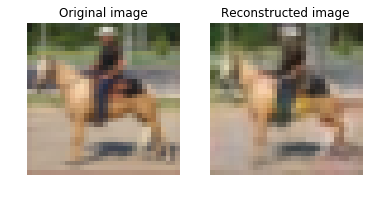

tensor([[[ 0.1255,  0.1725,  0.2431,  ...,  0.1490,  0.1373,  0.1451],
         [ 0.1059,  0.2039,  0.2314,  ...,  0.1451,  0.1569,  0.1647],
         [ 0.2157,  0.2431,  0.2314,  ...,  0.1490,  0.1137,  0.1725],
         ...,
         [ 0.7176,  0.7333,  0.7255,  ...,  0.6235,  0.6275,  0.7059],
         [ 0.7176,  0.7255,  0.7176,  ...,  0.7569,  0.7569,  0.7373],
         [ 0.6706,  0.6745,  0.6784,  ...,  0.7020,  0.7059,  0.6980]],

        [[ 0.1294,  0.2196,  0.2745,  ...,  0.2000,  0.1843,  0.1725],
         [ 0.1412,  0.2510,  0.2745,  ...,  0.2000,  0.2078,  0.1961],
         [ 0.2667,  0.2706,  0.2745,  ...,  0.2000,  0.1569,  0.1961],
         ...,
         [ 0.6353,  0.6549,  0.6549,  ...,  0.5373,  0.5451,  0.6157],
         [ 0.6275,  0.6471,  0.6392,  ...,  0.6667,  0.6627,  0.6392],
         [ 0.5412,  0.5686,  0.5647,  ...,  0.5804,  0.5804,  0.5569]],

        [[ 0.0863,  0.1176,  0.1725,  ...,  0.1412,  0.1333,  0.1216],
         [ 0.0784,  0.1412,  0.1608,  ...,  0

ValueError: Floating point image RGB values must be in the 0..1 range.

tensor([[[ 0.3255,  0.2627,  0.3647,  ...,  0.4000,  0.3922,  0.4078],
         [ 0.2980,  0.2471,  0.3608,  ...,  0.4078,  0.3412,  0.4235],
         [ 0.5137,  0.3255,  0.5608,  ...,  0.4824,  0.3255,  0.3804],
         ...,
         [ 0.3686,  0.4196,  0.6588,  ...,  0.2745,  0.2392,  0.2980],
         [ 0.3725,  0.4510,  0.5647,  ...,  0.2824,  0.2980,  0.3255],
         [ 0.3059,  0.3255,  0.3804,  ...,  0.3451,  0.2863,  0.2980]],

        [[ 0.3725,  0.3490,  0.4078,  ...,  0.3922,  0.4275,  0.4078],
         [ 0.3529,  0.3373,  0.4275,  ...,  0.3765,  0.3725,  0.4235],
         [ 0.5176,  0.3451,  0.5765,  ...,  0.4196,  0.3451,  0.3882],
         ...,
         [ 0.3765,  0.3725,  0.5725,  ...,  0.2902,  0.2392,  0.2549],
         [ 0.4392,  0.4667,  0.5176,  ...,  0.3216,  0.3255,  0.3255],
         [ 0.4275,  0.4235,  0.4196,  ...,  0.3843,  0.3373,  0.3686]],

        [[ 0.3569,  0.4157,  0.4196,  ...,  0.3451,  0.4118,  0.3647],
         [ 0.3412,  0.4039,  0.4588,  ...,  0

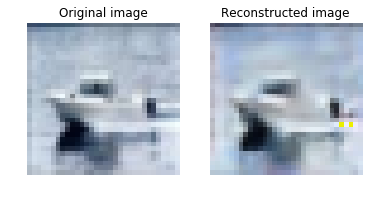

tensor([[[ 0.2275,  0.2235,  0.2039,  ...,  0.3725,  0.4039,  0.4431],
         [ 0.4510,  0.4667,  0.4471,  ...,  0.5804,  0.6157,  0.5922],
         [ 0.5529,  0.5882,  0.5765,  ...,  0.6510,  0.7020,  0.6902],
         ...,
         [ 0.7412,  0.8118,  0.7922,  ...,  0.7529,  0.7765,  0.8431],
         [ 0.6941,  0.7490,  0.7412,  ...,  0.7059,  0.7255,  0.8314],
         [ 0.6902,  0.7412,  0.7294,  ...,  0.7608,  0.7686,  0.8196]],

        [[ 0.2980,  0.2980,  0.2941,  ...,  0.4314,  0.4627,  0.4980],
         [ 0.5176,  0.5373,  0.5333,  ...,  0.6392,  0.6745,  0.6471],
         [ 0.6157,  0.6549,  0.6549,  ...,  0.7059,  0.7608,  0.7451],
         ...,
         [ 0.7922,  0.8588,  0.8392,  ...,  0.8000,  0.8235,  0.8863],
         [ 0.7412,  0.7922,  0.7843,  ...,  0.7451,  0.7647,  0.8667],
         [ 0.7255,  0.7765,  0.7647,  ...,  0.7922,  0.8000,  0.8471]],

        [[ 0.4039,  0.4157,  0.4157,  ...,  0.5059,  0.5373,  0.5686],
         [ 0.6157,  0.6431,  0.6471,  ...,  0

ValueError: Floating point image RGB values must be in the 0..1 range.

tensor([[[ 0.6078,  0.5961,  0.5451,  ...,  0.6863,  0.6745,  0.6510],
         [ 0.5882,  0.5882,  0.5529,  ...,  0.6863,  0.6627,  0.6353],
         [ 0.5922,  0.6039,  0.5569,  ...,  0.6706,  0.6471,  0.6118],
         ...,
         [ 0.1686,  0.1529,  0.1294,  ...,  0.3020,  0.2784,  0.3020],
         [ 0.1490,  0.0941,  0.0745,  ...,  0.3020,  0.2941,  0.3059],
         [ 0.2549,  0.1451,  0.0667,  ...,  0.2588,  0.3059,  0.3176]],

        [[ 0.6235,  0.6275,  0.5922,  ...,  0.6941,  0.6784,  0.6627],
         [ 0.6039,  0.6196,  0.5922,  ...,  0.6863,  0.6627,  0.6392],
         [ 0.6157,  0.6314,  0.5961,  ...,  0.6667,  0.6431,  0.6196],
         ...,
         [ 0.3843,  0.3804,  0.3686,  ...,  0.4314,  0.4392,  0.4706],
         [ 0.3647,  0.3373,  0.3412,  ...,  0.4431,  0.4549,  0.4627],
         [ 0.4510,  0.3804,  0.3373,  ...,  0.4118,  0.4549,  0.4588]],

        [[ 0.6588,  0.6549,  0.6157,  ...,  0.6745,  0.6588,  0.6510],
         [ 0.6235,  0.6353,  0.6039,  ...,  0

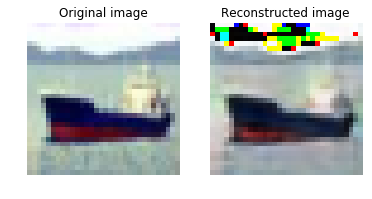

tensor([[[ 0.9922,  0.9725,  0.9451,  ...,  0.9647,  0.9373,  0.9412],
         [ 0.9922,  0.9922,  0.9843,  ...,  1.0000,  0.9804,  0.9725],
         [ 0.9765,  0.9765,  0.9804,  ...,  1.0000,  0.9843,  0.9529],
         ...,
         [ 0.7216,  0.7255,  0.6431,  ...,  0.6118,  0.5725,  0.5647],
         [ 0.6941,  0.7255,  0.6275,  ...,  0.5725,  0.5647,  0.5647],
         [ 0.6471,  0.6706,  0.5804,  ...,  0.5255,  0.6000,  0.5647]],

        [[ 0.9843,  0.9569,  0.9216,  ...,  0.9412,  0.9216,  0.9137],
         [ 0.9922,  0.9882,  0.9804,  ...,  0.9843,  0.9725,  0.9804],
         [ 0.9922,  0.9961,  1.0000,  ...,  0.9922,  0.9922,  0.9882],
         ...,
         [ 0.7451,  0.7608,  0.7059,  ...,  0.6863,  0.6353,  0.6000],
         [ 0.7176,  0.7608,  0.6980,  ...,  0.6471,  0.6235,  0.6000],
         [ 0.6745,  0.7098,  0.6549,  ...,  0.6039,  0.6588,  0.6000]],

        [[ 1.0000,  1.0000,  0.9961,  ...,  0.9961,  0.9843,  0.9843],
         [ 1.0000,  1.0000,  1.0000,  ...,  0

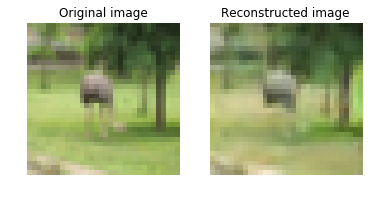

tensor([[[ 0.5333,  0.5333,  0.4902,  ...,  0.1216,  0.1333,  0.1294],
         [ 0.6471,  0.5922,  0.5059,  ...,  0.1294,  0.1294,  0.1255],
         [ 0.6824,  0.6471,  0.5216,  ...,  0.1529,  0.1294,  0.1255],
         ...,
         [ 0.6706,  0.6549,  0.7176,  ...,  0.6275,  0.6431,  0.5961],
         [ 0.6824,  0.6392,  0.6196,  ...,  0.6078,  0.6118,  0.6000],
         [ 0.7961,  0.7686,  0.6980,  ...,  0.6118,  0.6196,  0.6157]],

        [[ 0.5882,  0.6235,  0.5882,  ...,  0.1647,  0.1804,  0.1765],
         [ 0.6118,  0.6431,  0.5843,  ...,  0.1804,  0.1765,  0.1725],
         [ 0.6471,  0.6275,  0.5647,  ...,  0.2078,  0.1804,  0.1804],
         ...,
         [ 0.6314,  0.6314,  0.6980,  ...,  0.6980,  0.7020,  0.6784],
         [ 0.6588,  0.6078,  0.5922,  ...,  0.6902,  0.6824,  0.6863],
         [ 0.7765,  0.7216,  0.6588,  ...,  0.7020,  0.7059,  0.7020]],

        [[ 0.3569,  0.3804,  0.3608,  ...,  0.0941,  0.1098,  0.1020],
         [ 0.4784,  0.4588,  0.3647,  ...,  0

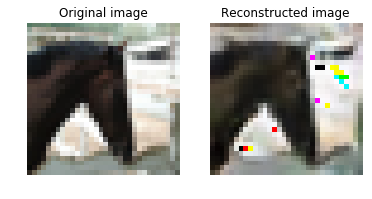

tensor([[[ 0.3294,  0.3843,  0.3882,  ...,  0.6980,  0.6510,  0.6275],
         [ 0.5569,  0.7333,  0.6706,  ...,  0.7451,  0.6902,  0.6980],
         [ 0.7098,  0.7451,  0.6941,  ...,  0.6863,  0.6627,  0.7098],
         ...,
         [ 0.0667,  0.0471,  0.0863,  ...,  0.4471,  0.4588,  0.4510],
         [ 0.0314,  0.1098,  0.3569,  ...,  0.4824,  0.4314,  0.4471],
         [ 0.1725,  0.4078,  0.5373,  ...,  0.5529,  0.4980,  0.3333]],

        [[ 0.4706,  0.4902,  0.4902,  ...,  0.7451,  0.6627,  0.6667],
         [ 0.6196,  0.7137,  0.6588,  ...,  0.7843,  0.6941,  0.7255],
         [ 0.7529,  0.7686,  0.7255,  ...,  0.7216,  0.6627,  0.7294],
         ...,
         [ 0.0627,  0.0431,  0.0745,  ...,  0.4627,  0.4706,  0.4902],
         [ 0.0353,  0.0863,  0.3255,  ...,  0.5020,  0.4431,  0.4824],
         [ 0.1490,  0.3804,  0.5569,  ...,  0.5804,  0.5176,  0.3529]],

        [[ 0.3843,  0.4039,  0.4118,  ...,  0.6627,  0.5961,  0.5686],
         [ 0.5686,  0.6667,  0.6000,  ...,  0

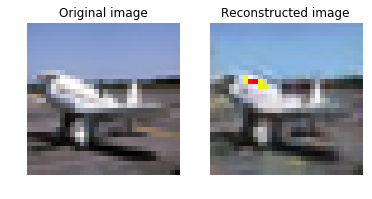

tensor([[[ 0.4471,  0.4510,  0.4549,  ...,  0.4706,  0.4706,  0.4667],
         [ 0.4627,  0.4667,  0.4706,  ...,  0.4863,  0.4863,  0.4863],
         [ 0.4784,  0.4824,  0.4863,  ...,  0.5059,  0.5059,  0.5059],
         ...,
         [ 0.3765,  0.3725,  0.3843,  ...,  0.3294,  0.3373,  0.3569],
         [ 0.4431,  0.4667,  0.4667,  ...,  0.3216,  0.3020,  0.2549],
         [ 0.4235,  0.4157,  0.4118,  ...,  0.3216,  0.2000,  0.0431]],

        [[ 0.5569,  0.5608,  0.5647,  ...,  0.5765,  0.5765,  0.5725],
         [ 0.5686,  0.5725,  0.5725,  ...,  0.5882,  0.5843,  0.5843],
         [ 0.5765,  0.5843,  0.5843,  ...,  0.5961,  0.5961,  0.5922],
         ...,
         [ 0.3490,  0.3451,  0.3529,  ...,  0.2941,  0.3020,  0.3255],
         [ 0.4196,  0.4392,  0.4275,  ...,  0.2902,  0.2784,  0.2353],
         [ 0.4000,  0.3882,  0.3725,  ...,  0.2980,  0.1843,  0.0314]],

        [[ 0.7725,  0.7725,  0.7804,  ...,  0.7882,  0.7882,  0.7843],
         [ 0.7765,  0.7804,  0.7882,  ...,  0

ValueError: Floating point image RGB values must be in the 0..1 range.

tensor([[[ 0.0667,  0.0902,  0.1098,  ...,  0.1804,  0.1922,  0.1961],
         [ 0.0510,  0.0588,  0.0667,  ...,  0.2314,  0.2275,  0.2078],
         [ 0.0902,  0.0627,  0.0549,  ...,  0.2471,  0.2353,  0.2078],
         ...,
         [ 0.1098,  0.1098,  0.1216,  ...,  0.8588,  0.8627,  0.8784],
         [ 0.2118,  0.2196,  0.2353,  ...,  0.7804,  0.7451,  0.7451],
         [ 0.2118,  0.2196,  0.2431,  ...,  0.8392,  0.7843,  0.7725]],

        [[ 0.0118,  0.0078,  0.0039,  ...,  0.1137,  0.1333,  0.1216],
         [ 0.0196,  0.0039,  0.0000,  ...,  0.1373,  0.1569,  0.1490],
         [ 0.0588,  0.0196,  0.0039,  ...,  0.1020,  0.1412,  0.1490],
         ...,
         [ 0.1451,  0.1451,  0.1529,  ...,  0.9804,  0.9843,  0.9843],
         [ 0.2667,  0.2706,  0.2902,  ...,  0.9294,  0.9216,  0.9255],
         [ 0.2863,  0.2902,  0.3059,  ...,  0.9843,  0.9569,  0.9373]],

        [[ 0.0118,  0.0118,  0.0118,  ...,  0.0471,  0.0667,  0.0510],
         [ 0.0157,  0.0039,  0.0039,  ...,  0

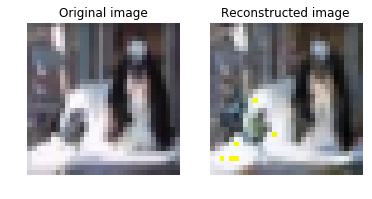

tensor([[[ 0.3725,  0.3647,  0.3765,  ...,  0.3137,  0.2784,  0.2039],
         [ 0.4039,  0.4078,  0.4784,  ...,  0.3490,  0.3020,  0.2157],
         [ 0.4667,  0.4667,  0.5098,  ...,  0.3765,  0.3176,  0.2275],
         ...,
         [ 0.8745,  0.9569,  0.9804,  ...,  0.3608,  0.2706,  0.3529],
         [ 0.8627,  0.8980,  0.9098,  ...,  0.2549,  0.2471,  0.2549],
         [ 0.8118,  0.8235,  0.8353,  ...,  0.2275,  0.2078,  0.2118]],

        [[ 0.3843,  0.3608,  0.3490,  ...,  0.3137,  0.2706,  0.1804],
         [ 0.4000,  0.3961,  0.4471,  ...,  0.3451,  0.2941,  0.1961],
         [ 0.4510,  0.4431,  0.4745,  ...,  0.3725,  0.3098,  0.2078],
         ...,
         [ 0.8706,  0.9412,  0.9490,  ...,  0.3804,  0.2902,  0.3725],
         [ 0.8588,  0.8824,  0.8784,  ...,  0.2588,  0.2510,  0.2588],
         [ 0.8039,  0.8118,  0.8078,  ...,  0.2196,  0.2000,  0.2039]],

        [[ 0.3608,  0.3529,  0.3608,  ...,  0.3333,  0.3059,  0.2157],
         [ 0.3765,  0.3804,  0.4510,  ...,  0

ValueError: Floating point image RGB values must be in the 0..1 range.

tensor([[[ 0.2667,  0.2157,  0.3176,  ...,  0.5412,  0.6118,  0.6863],
         [ 0.2745,  0.2275,  0.3255,  ...,  0.5373,  0.6431,  0.6902],
         [ 0.2706,  0.2431,  0.3176,  ...,  0.5569,  0.6824,  0.7020],
         ...,
         [ 0.1765,  0.1961,  0.2706,  ...,  0.3059,  0.4549,  0.4353],
         [ 0.1686,  0.2000,  0.2627,  ...,  0.5176,  0.5216,  0.4000],
         [ 0.1647,  0.2000,  0.2588,  ...,  0.4941,  0.3765,  0.2980]],

        [[ 0.1725,  0.1059,  0.1804,  ...,  0.4275,  0.4863,  0.5529],
         [ 0.1686,  0.1098,  0.1765,  ...,  0.4235,  0.5176,  0.5490],
         [ 0.1569,  0.1137,  0.1608,  ...,  0.4353,  0.5490,  0.5529],
         ...,
         [ 0.0706,  0.0784,  0.1294,  ...,  0.2667,  0.4078,  0.3843],
         [ 0.0667,  0.0824,  0.1255,  ...,  0.4627,  0.4627,  0.3529],
         [ 0.0588,  0.0824,  0.1255,  ...,  0.4392,  0.3333,  0.2706]],

        [[ 0.0510,  0.0039,  0.0431,  ...,  0.2353,  0.2235,  0.2549],
         [ 0.0471,  0.0039,  0.0353,  ...,  0

In [12]:



check_accuracy_part34(loader_test, model)

i = 0
for original,reconstruction in images.items():
    if i < 11:
        plt.figure()
        org = original.detach().numpy().transpose(1,2,0)
        plt.subplot(1, 2, 1)
        imshow_noax(original.detach().numpy().transpose(1,2,0), normalize=False)
        plt.title('Original image')
        plt.subplot(1, 2, 2)
        rec = reconstruction.detach().numpy().transpose(1,2,0)
        imshow_noax(reconstruction.detach().numpy().transpose(1,2,0), normalize=False)
        plt.title('Reconstructed image')
        plt.show()
        print(original)
        print(reconstruction)
        print(((org - rec) ** 2).sum(axis=None))
        i += 1
    else: 
        break

